# Grideye Cubicle Data
*Kernel > Restart & Run All*

In [79]:
# Imports
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from IPython.display import HTML, display
from timeit import timeit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # Module to split the data
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score #Classification report and confusion matrix to evaluate predictions

import tqdm
try:
    from tqdm import tqdm_notebook,tnrange,tqdm_pandas,tqdm
except ModuleNotFoundError:
    !pip install tqdm
    from tqdm import tqdm_notebook,tnrange,tqdm_pandas,tqdm
tqdm.pandas()

try:
    import jupyternotify
except ModuleNotFoundError:
    !pip install jupyternotify
    import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
#notify if cell is finished for cells taking longer than 30 seconds
%autonotify -a 30

<IPython.core.display.Javascript object>

In [36]:
# Loading the JSON data from the file
with open("betterTransitionlessData.json", "r") as jsonFile:
    jsonList = json.load(jsonFile)

### Creating the dataframes
There are 3 different dataframes that have been made for accessing the data easily, in whichever format works best for you.

 - **cubicleData_allInfo** has all of the information, including the states, and has the temperature arrays structured in a way that represents how they are physically recorded.
 
 - **cubicleData_essentialInfo_structured** has the temperature arrays structured like how they're physically recorded, and has the states of each row (i.e. either sitting, standing, or empty), but no other information.
 
 - **cubicleData_essentialInfo_flat** has each of the temperature values from the array flattened in order in seperate columns of the dataframe, as well as what the state of that entry is.

In [37]:
tempArrays = [entry["temps"] for entry in jsonList]
states = [entry["state"] for entry in jsonList]
names = [entry["name"] for entry in jsonList]
times = [entry["time"] for entry in jsonList]
    
cubicleData_allInfo = pd.DataFrame(data={"State": states, "TemperatureArray": tempArrays, "ID": names, "Time": times})
#print(cubicleData)
cubicleData_essentialInfo_structured = pd.DataFrame(data={"State": states, "TemperatureArray": tempArrays})

flatLists = []
for index in range(len(tempArrays)):
    arrayList = [states[index]]
    for subList in tempArrays[index]:
        arrayList.extend(subList)
    flatLists.append(arrayList)

cubicleData_essentialInfo_flat = pd.DataFrame(flatLists,columns = ["State"]+list(range(64)))

Here are some examples of how the dataframes are structured:

In [38]:
print("cubicleData_allInfo")
cubicleData_allInfo.sample(10)

cubicleData_allInfo


,State,TemperatureArray,ID,Time
4984,sitting,"[[24.25, 22.75, 22.25, 22.75, 23.25, 23.75, 23...",human_6,1.545095e+09
3701,sitting,"[[23.0, 23.0, 22.75, 22.25, 23.0, 23.0, 23.0, ...",human_0,1.545094e+09
4775,sitting,"[[23.0, 22.75, 22.0, 22.75, 22.5, 22.75, 23.0,...",human_3,1.545112e+09
4280,empty,"[[23.75, 23.75, 23.0, 22.75, 23.0, 23.75, 22.7...",human_5,1.545095e+09
1797,empty,"[[23.25, 23.25, 21.5, 21.75, 23.0, 22.5, 22.75...",human_1,1.545113e+09
5060,empty,"[[23.0, 23.5, 21.75, 22.0, 22.75, 22.5, 22.5, ...",human_0,1.545094e+09
4101,empty,"[[23.25, 23.75, 22.0, 22.25, 23.0, 22.75, 22.7...",human_3,1.545112e+09
793,sitting,"[[23.25, 23.5, 22.25, 23.25, 23.0, 23.5, 23.0,...",human_8,1.545094e+09
3816,standing,"[[23.25, 22.25, 21.5, 21.75, 22.0, 22.5, 22.25...",human_0,1.545094e+09
4847,empty,"[[23.75, 23.5, 22.75, 22.5, 22.75, 23.5, 22.75...",human_7,1.545113e+09


In [39]:
print("cubicleData_essentialInfo_structured")
cubicleData_essentialInfo_structured.sample(10)

cubicleData_essentialInfo_structured


,State,TemperatureArray
4384,sitting,"[[23.75, 23.5, 22.0, 23.25, 22.75, 23.5, 23.0,..."
1069,sitting,"[[23.5, 23.0, 22.0, 22.5, 23.0, 23.75, 22.75, ..."
937,empty,"[[23.75, 23.0, 22.0, 21.75, 23.0, 23.0, 22.75,..."
4837,sitting,"[[24.0, 22.75, 22.25, 22.25, 22.5, 23.75, 22.7..."
5379,empty,"[[23.0, 22.75, 22.25, 22.5, 22.5, 22.25, 22.5,..."
4071,sitting,"[[23.75, 23.5, 22.25, 23.25, 22.75, 23.5, 23.0..."
4715,empty,"[[23.5, 23.5, 22.75, 23.0, 22.75, 23.5, 23.5, ..."
1163,standing,"[[23.5, 23.25, 21.5, 22.0, 22.5, 23.0, 23.0, 2..."
4675,standing,"[[22.75, 23.5, 22.5, 22.5, 22.5, 23.0, 22.75, ..."
445,empty,"[[23.25, 23.5, 22.0, 22.25, 22.75, 23.5, 23.25..."


In [40]:
print("cubicleData_essentialInfo_flat")
cubicleData_essentialInfo_flat.sample(10)

cubicleData_essentialInfo_flat


,State,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
1192,standing,23.50,23.25,21.50,21.75,23.00,23.00,23.50,22.50,23.75,...,24.00,23.50,23.75,23.50,24.25,27.25,27.00,24.75,24.25,25.00
4804,standing,24.00,23.75,22.50,22.75,23.25,23.00,23.25,22.50,24.00,...,24.25,24.50,24.00,23.75,25.75,28.50,28.25,26.00,25.25,24.25
1853,sitting,24.00,23.50,23.75,23.00,23.50,23.00,23.25,23.25,24.00,...,24.75,24.25,24.00,24.00,24.50,24.75,24.50,24.00,24.75,23.75
65,empty,24.25,23.50,22.50,23.00,22.75,24.00,23.75,22.75,24.50,...,24.50,24.50,24.25,23.75,25.00,24.75,24.25,24.25,25.25,24.00
2923,standing,23.00,23.50,22.00,22.75,22.25,23.75,23.50,22.50,23.00,...,23.50,23.75,23.75,23.50,23.75,26.75,26.50,24.00,25.00,23.75
2204,empty,23.50,23.00,22.75,23.00,22.75,23.25,23.00,22.50,23.50,...,23.75,23.25,23.75,24.00,24.25,24.00,24.50,24.25,24.00,23.75
732,sitting,22.75,23.00,22.00,22.25,22.50,22.75,22.25,22.50,23.25,...,24.25,23.50,23.25,23.75,24.00,24.25,24.25,24.00,23.75,22.75
5463,standing,23.50,23.00,21.75,22.25,22.50,23.75,23.00,22.50,23.75,...,23.75,23.50,24.25,23.25,25.25,28.50,25.50,24.75,24.25,23.75
1070,empty,23.25,23.00,21.75,22.75,22.25,22.50,22.50,22.25,23.50,...,23.75,23.25,23.50,23.75,23.75,23.75,23.25,22.50,23.00,24.25
2459,standing,23.25,22.75,22.25,22.75,21.75,22.75,23.00,22.00,23.00,...,24.00,24.00,23.50,24.00,24.25,26.50,27.25,24.50,24.25,23.50


# General descriptive investigation

cubicleData_essentialInfo_flat has 5592 rows (observations)

The temperature range captured was between 20.5°C and 30.5°C

The distribution of observations between the classes is:
standing    1926
sitting     1905
empty       1761
Name: State, dtype: int64


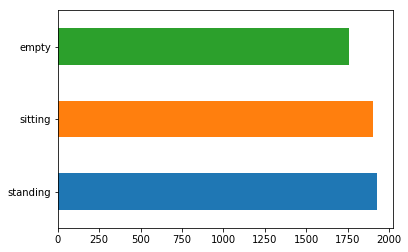

In [41]:
print(
    (
        "cubicleData_essentialInfo_flat has {rows} rows (observations)\n\n"
        "The temperature range captured was between {min}°C and {max}°C\n\n"
        "The distribution of observations between the classes is:\n{counts}"
    ).format(
        rows=cubicleData_essentialInfo_flat.shape[0],
        max=cubicleData_essentialInfo_flat.drop("State", 1).max().max(),
        min=cubicleData_essentialInfo_flat.drop("State", 1).min().min(),
        counts=cubicleData_essentialInfo_flat.State.value_counts()
    )
)

cubicleData_essentialInfo_flat.State.value_counts().plot(kind="barh");

## Quickly exploring some of the data

Now that we've imported all of the data nicely, lets do a quick dive into some of the characteristics of the data.

First off, we'll look at what the averages of each state look like.

In [42]:
def pixelStats(state=None, process="mean"):
    """
    Given a described state (e.g. "standing"), get the average of each of the pixel arrays
    of that state and visualise the result.
    """
    if state != None:
        if process == "mean":
            meanSeries = cubicleData_essentialInfo_flat[cubicleData_essentialInfo_flat[0]==state].mean(0)
        elif process == "std":
            meanSeries = cubicleData_essentialInfo_flat[cubicleData_essentialInfo_flat[0]==state].std(0)
        print(state.upper()[0] + state.lower()[1:] + " " + process)
    else:
        if process == "mean":
            meanSeries = cubicleData_essentialInfo_flat.mean(0)
        elif process == "std":
            meanSeries = cubicleData_essentialInfo_flat.std(0)
        print(process.upper()[0] + process.lower()[1:])
    pixelList = meanSeries.tolist()
    pixelArray = np.reshape(np.array(pixelList), (8,8))
    f, ax = plt.subplots(figsize=(9, 6))
    if process == "mean":
        sns.heatmap(pixelArray, annot=True, fmt='.4g', vmin=21, vmax=28, linewidths=0, ax=ax)
    elif process == "std":
        sns.heatmap(pixelArray, annot=True, fmt='.4g', vmin=0, vmax=1.8, cmap="winter", linewidths=0, ax=ax)

In [43]:
def pixelStats(state=None):
    """
    Given a described state (e.g. "standing"), get the average of each of the pixel arrays
    of that state and visualise the result.
    """
    if state != None:
        mean_series = cubicleData_essentialInfo_flat[cubicleData_essentialInfo_flat.State==state].mean(0)
        std_series  = cubicleData_essentialInfo_flat[cubicleData_essentialInfo_flat.State==state].std(0)
        
    else:
        mean_series = cubicleData_essentialInfo_flat.mean(0)
        std_series  = cubicleData_essentialInfo_flat.std(0)

    mean_pixel_array = np.reshape(np.array(mean_series.tolist()), (8,8))
    std_pixel_array  = np.reshape(np.array(std_series.tolist()), (8,8))

    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(16, 6))
    sns.heatmap(mean_pixel_array, annot=True, fmt='.4g', vmin=21, vmax=28, linewidths=0, ax=ax1).set_title('Mean')
    sns.heatmap(std_pixel_array,  annot=True, fmt='.4g', vmin=0, vmax=1.8, cmap="winter", linewidths=0, ax=ax2).set_title('Standard Deviation')
    if state:
        plt.suptitle(state)
    else:
        plt.suptitle("All data", fontsize=18)


Regardless of what state the entry is in, here's what the average temperature for each pixel looks like:

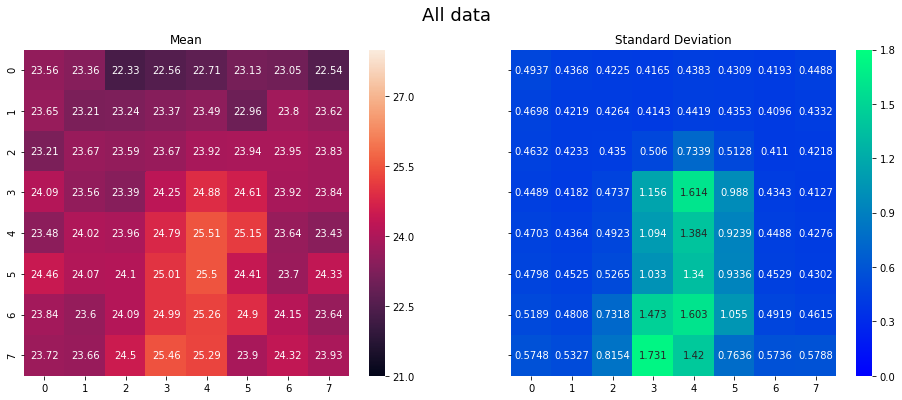

In [44]:
pixelStats();

We can see that there's a lot of heat going on in the centre, especially down the bottom, with not much at all at the top.

Here's the data of the empty state:

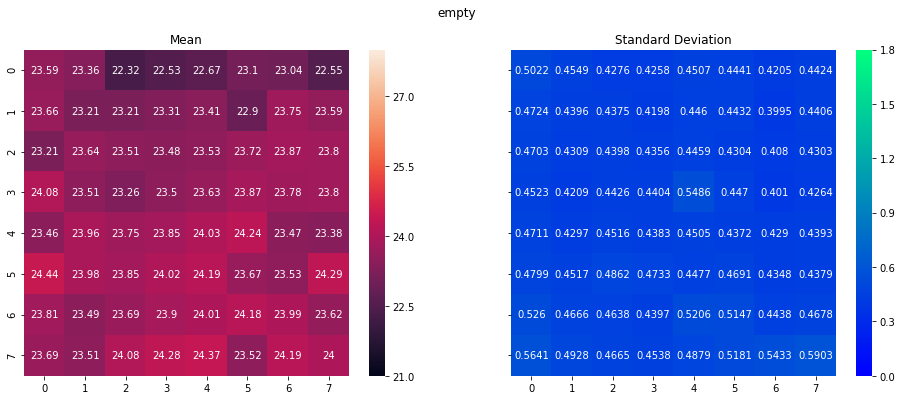

In [45]:
pixelStats(state="empty")

The data looks somewhat more homogenous, especially when taking into consideration the smaller heat range (approx 90-98).

Here's what the average heat of the standing & sitting positions look like:

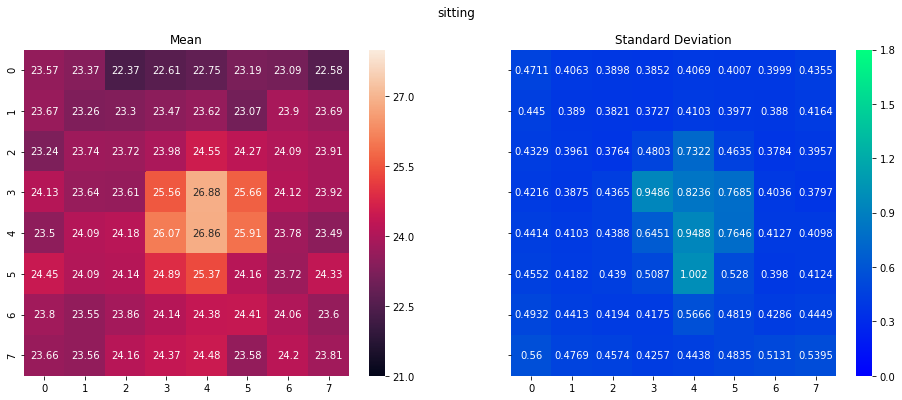

In [46]:
pixelStats(state="sitting")

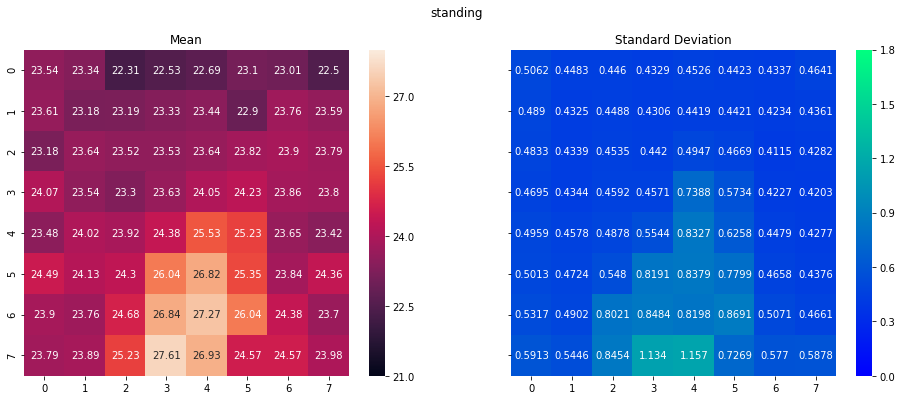

In [47]:
pixelStats(state="standing")

Both having much larger ranges, homogeneity is much less prevelant. Hopefully the distinction between the three states is enough for some easy classification!

Here's the standard deviation of each pixel regardless of state:

# Classification alogorithm comparisons

---

## [K Nearest Neighbours (KNN)](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)

![](https://upload.wikimedia.org/wikipedia/commons/e/e7/KnnClassification.svg)



In [48]:
# use sklearn.preprocessing's StandardScaler to standardize the scale
# Create instance (i.e. object) of the standard scaler
scaler = StandardScaler()
# Fit the object to all the data except the Target Class
# use the .drop() method to gather all features except Target Class
# axis -> argument refers to columns; a 0 would represent rows
scaler.fit(cubicleData_essentialInfo_flat.drop('State', axis=1))
scaled_features = scaler.transform(cubicleData_essentialInfo_flat.drop('State', axis=1))

scaledDF = pd.DataFrame(scaled_features, columns=cubicleData_essentialInfo_flat.columns[1:])
scaledDF.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
3129,0.882598,1.472207,-0.782734,-0.133336,2.379305,0.858008,-0.114298,1.573775,-0.312719,0.676213,...,1.220858,1.318451,0.495739,0.643885,0.305026,-0.264774,-0.556168,0.129226,1.177977,1.419095
4391,0.882598,-0.817165,1.584199,0.466997,1.238414,0.858008,1.674386,1.016672,2.348155,-0.508988,...,0.204325,0.235016,1.365712,2.051836,0.611642,1.324182,1.556905,2.093790,0.742082,-1.172538
3229,-0.130329,-0.244822,0.400732,0.466997,-0.472923,0.277841,-0.114298,-1.211738,0.219455,0.676213,...,-0.812209,-2.473574,-0.374235,1.113202,-0.308206,-0.409225,-0.556168,-1.180483,-0.129708,-0.308660
2734,2.401989,-0.244822,0.400732,1.067329,0.097523,-2.042826,0.481930,-0.097533,0.751630,-0.508988,...,0.204325,0.235016,0.930725,1.113202,0.305026,1.035281,0.324279,0.129226,1.177977,-1.172538
5021,-0.130329,0.899864,-0.191001,0.466997,0.667968,1.438175,1.078158,-0.097533,-0.844894,0.083613,...,-0.303942,-0.306702,0.060752,-0.294750,-0.614822,1.035281,-0.203989,0.784081,-0.129708,0.555217


In [49]:
# Substantially riped off from here:
# https://medium.com/@kbrook10/day-11-machine-learning-using-knn-k-nearest-neighbors-with-scikit-learn-350c3a1402e6

# Module for KNN
from sklearn.neighbors import KNeighborsClassifier

In [50]:
# Set the X and ys
X = scaledDF
y = cubicleData_essentialInfo_flat['State']
# Use the train_test_split() method to split the data into respective sets
# test_size -> argument refers to the size of the test subset
# random_state -> argument ensures guarantee that the output of Run 
# 1 will be equal to the output of Run 2, i.e. your split will be always the same
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [51]:
# Create KNN instance
# n_neighbors -> argument identifies the amount of neighbors used to ID classification
knn = KNeighborsClassifier(n_neighbors=1)
# Fit (i.e. traing) the model
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [52]:
# Use the .predict() method to make predictions from the X_test subset
pred = knn.predict(X_test)
# Review the predictions
# pred

In [53]:
# Print out classification report and confusion matrix
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

      empty       0.98      1.00      0.99       529
    sitting       1.00      0.98      0.99       572
   standing       1.00      1.00      1.00       577

avg / total       0.99      0.99      0.99      1678



[[528   1   0]
 [ 10 562   0]
 [  0   0 577]]
TP - True Negative   528
FP - False Positive    1
FN - False Negative   10
TP - True Positive   562
Accuracy Rate: 0.6495828367103695
Misclassification Rate: 0.006555423122765197


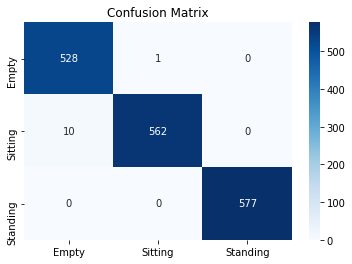

In [54]:
# Print out confusion matrix
def show_confusion(y_test, pred):
    cmat = confusion_matrix(y_test, pred)
    print(cmat)
    print('TP - True Negative  {:>4}'.format(cmat[0,0]))
    print('FP - False Positive {:>4}'.format(cmat[0,1]))
    print('FN - False Negative {:>4}'.format(cmat[1,0]))
    print('TP - True Positive  {:>4}'.format(cmat[1,1]))
    print('Accuracy Rate: {}'.format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat))))
    print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[0,1],cmat[1,0]]),np.sum(cmat))))
    cm = pd.DataFrame(cmat, 
                      index=  ["Empty", "Sitting", "Standing"], 
                      columns=["Empty", "Sitting", "Standing"])
    sns.heatmap(cm, cmap='Blues', annot=True, fmt='g').set_title('Confusion Matrix');
show_confusion(y_test, pred)

In [59]:
# Generate function to add error rates of KNN with various k-values
# error_rate -> empty list to gather error rates at various k-values
# for loop -> loops through k values 1 to 39
# knn -> creates instance of KNeighborsClassifier with various k
# knn.fit -> trains the model
# pred_i -> conducts predictions from model on test subset
# error_rate.append -> adds error rate of model with various k-value, using the average where prediction not
# equal to the test values
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

In [60]:
print(timeit("knn.predict(X_test)", "from __main__ import knn, X_test", number=10))
print(len(X_test))

10.24827909999999
1678


Text(0,0.5,'Error Rate')

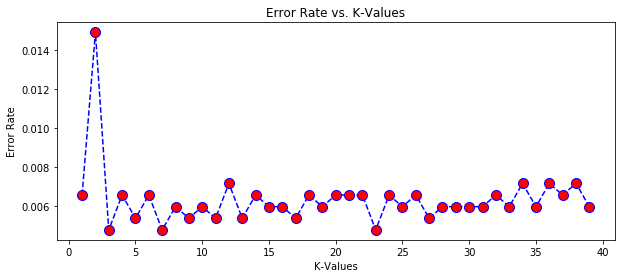

In [62]:
# Configure and plot error rate over k values
plt.figure(figsize=(10,4))
plt.plot(range(1,40), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K-Values')
plt.xlabel('K-Values')
plt.ylabel('Error Rate')

# SVM Classifier

## get sklearn function

In [63]:
from sklearn import svm

## split into train and test
__X_train__/__X_test__ represents the flattened grideye pixels
__y_train__/__y_test__ are the labels (__empty__, __sitting__, __standing__) 

```python
train_test_split() 
```
randomly splits data into `test_size` (i.e. 0.9 would produce `0.1×data size` of training data and `0.9×data size` of test data)

and requires the input array to be a numpy array

In [64]:
# Split arrays or matrices into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(np.array(cubicleData_essentialInfo_flat.loc[:, cubicleData_essentialInfo_flat.columns != "State"]),
                               np.array(cubicleData_essentialInfo_flat["State"]), test_size=0.3)
print(X_train.shape, y_train.shape)

(3914, 64) (3914,)


## Create a classifier: a support vector classifier (SVC) and fit it

In [65]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)
#fit to the training data
classifier.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [66]:
#Using CPickle to export the classifier object
with open("supportVectorMachine_Aiden.pkl", 'wb') as myFile:
    pickle.dump(classifier, myFile, protocol=1)

## predict the classes
Use the now trained classifier to predict the clases of the test data
- empty
- sitting
- standing

In [67]:
y_pred = classifier.predict(X_test)

# Results (50% train-test split)

In [68]:
print("Classification report for classifier\n %s:\n\n%s\n"
      % (classifier, classification_report(y_test, y_pred)))

Classification report for classifier
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):

             precision    recall  f1-score   support

      empty       1.00      1.00      1.00       520
    sitting       1.00      1.00      1.00       575
   standing       1.00      1.00      1.00       583

avg / total       1.00      1.00      1.00      1678




The precision, recall, and f1-score (measurements of "accuracy") of each class are 100%.  
I.e. the algorithm did not make a single mistake! (at least on the data it was given)

## Confusion Matrix
A confusion matrix is a pretty way to display classification results.  
The columns represent the predicted class and the rows are the actual class.   
Therefore the diagonal cells are the correct predictions and every other cell shows incorrect predictions.  
As there are only zeroes in the non-diagonal cells we see there are no incorrect predictions! 

[[520   0   0]
 [  0 575   0]
 [  0   0 583]]
TP - True Negative   520
FP - False Positive    0
FN - False Negative    0
TP - True Positive   575
Accuracy Rate: 0.6525625744934446
Misclassification Rate: 0.0


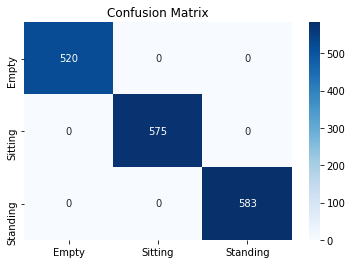

In [69]:
show_confusion(y_test, y_pred)

## Accuracy
Accuracy isn't typically a good measure for times series.  
however, given I have not treated the data as such it is a nice single number to compare to other algorithms. 

In [73]:
display(HTML("<font size='5'><b>Accuracy:</b></br>{0:.3f}%</font>".format(accuracy_score(y_test, y_pred)*100)))

## Show frames in which it incorrectly predicted 
(if the output is empty there are no mistakes!)

In [74]:
for test, pred, label in zip(X_test, y_pred, y_test):
    if pred != label:
        plt.figure()
        sns.heatmap(test.reshape((8,8)), annot=True, fmt='.4g', vmin=21, vmax=28).set_title("predicted: {} | actual: {}".format(pred, label))
        #print(test, 'has been classified as ', pred, 'and should be ', label)

##  Accuracy and f1 score drop off given batch size
Ok so the classifier is pretty amazing.
To play around with it a bit let's give it less and less data to train on to see when it fails.

In [80]:
y_preds = []
num_repeats = 5
train_test_split_step = 0.001
train_test_split_min = 0.85
train_test_split_max = 0.999

for batch in tqdm(np.arange(train_test_split_min, train_test_split_max, train_test_split_step)):
    for batch_repeat in range(num_repeats):
        repeat_accuracy = []
        repeat_f1_empty = []
        repeat_f1_sitting = []
        repeat_f1_standing = []
        repeat_f1_total = []
        
        # Split arrays or matrices into random train and test subsets
        X_train, X_test, y_train, y_test = train_test_split(np.array(cubicleData_essentialInfo_flat.loc[:, cubicleData_essentialInfo_flat.columns != "State"]),
                                       np.array(cubicleData_essentialInfo_flat["State"]), test_size=batch)
        #print(X_train.shape, y_train.shape)

        # Create a classifier: a support vector classifier
        classifier = svm.SVC(gamma=0.001)
        #fit to the trainin data
        classifier.fit(X_train,y_train)

        # now to Now predict the value of the digit on the test data
        y_pred = classifier.predict(X_test)
        repeat_accuracy.append(accuracy_score(y_test, y_pred))
        
        class_f1_scores = f1_score(y_test, y_pred, average=None)
        f1_empty = class_f1_scores[0]
        f1_sitting = class_f1_scores[1]
        f1_standing = class_f1_scores[2]
        f1_total = np.mean(class_f1_scores)
        
        repeat_f1_empty.append(f1_empty)
        repeat_f1_sitting.append(f1_sitting)
        repeat_f1_standing.append(f1_standing)
        repeat_f1_total.append(f1_total)
                
    y_preds.append([batch, np.mean(repeat_accuracy), np.mean(repeat_f1_empty),
                    np.mean(repeat_f1_sitting), np.mean(repeat_f1_standing), np.mean(repeat_f1_total)])
    
prediction_batches = pd.DataFrame(y_preds,columns=["batch size","accuracy","empty_f1","sitting_f1","standing_f1","total_f1"])
prediction_batches.set_index("batch size", inplace=True)

 94%|█████████████████████████████████████▌  | 141/150 [01:31<00:03,  2.64it/s]Q:\Users\bdoherty\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
 95%|█████████████████████████████████████▊  | 142/150 [01:31<00:02,  2.70it/s]Q:\Users\bdoherty\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
Q:\Users\bdoherty\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
 95%|██████████████████████████████████████▏ | 143/150 [

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## remove split data where a class does not exists in the training set and interpolate it
this is neccessary as once 

In [81]:
prediction_batches = prediction_batches[(prediction_batches["empty_f1"] != 0) \
                   & (prediction_batches["sitting_f1"] != 0) \
                   & (prediction_batches["standing_f1"] != 0)]
prediction_batches = prediction_batches.reindex(np.arange(0.85, 0.999, 0.001))
prediction_batches = prediction_batches.interpolate()

## plot the accuracy and f1 score drop off given test/train split

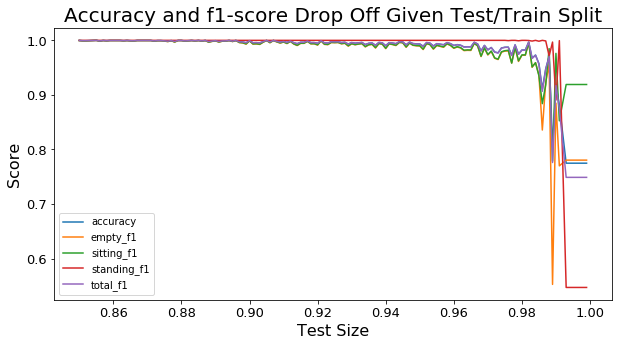

In [82]:
ax = prediction_batches.plot(figsize=(10,5), fontsize=13)
ax.set_xlabel("Test Size", fontsize=16)
ax.set_ylabel("Score", fontsize=16)
ax.set_title("Accuracy and f1-score Drop Off Given Test/Train Split", fontsize=20);

We can see it still does amazingly well given only 2% of the data.   
Once it hits 0.995 (0.5% of the data) it quickly drops off. 

Therefore, given greater than 30 training images the SVM classiffier can achieve over 90% accuracy.

In [83]:
from timeit import timeit
print(timeit("classifier.predict(X_test)", "from __main__ import classifier, X_test", number=10000))
print(len(X_test))

36.13007360000006
5587


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Neural Network

In [84]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_digits

In [88]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(
        cubicleData_essentialInfo_flat.loc[
            :, cubicleData_essentialInfo_flat.columns != "State"
        ]
    ),
    np.array(cubicleData_essentialInfo_flat[0]),
    test_size=0.3,
)
(X_train, X_test, y_train, y_test)

(array([[24.  , 23.75, 22.5 , ..., 24.5 , 24.5 , 24.25],
        [23.25, 23.5 , 22.75, ..., 24.  , 23.75, 23.5 ],
        [24.5 , 23.75, 22.5 , ..., 24.5 , 24.75, 24.5 ],
        ...,
        [23.5 , 23.25, 22.  , ..., 23.25, 24.5 , 24.  ],
        [23.25, 23.  , 22.5 , ..., 23.5 , 24.25, 24.  ],
        [23.75, 23.75, 23.  , ..., 25.25, 25.75, 23.75]]),
 array([[24.  , 23.75, 22.  , ..., 23.75, 24.25, 23.75],
        [23.75, 23.25, 22.75, ..., 24.75, 23.75, 24.25],
        [23.25, 22.75, 22.  , ..., 23.5 , 23.75, 23.  ],
        ...,
        [23.75, 23.  , 22.  , ..., 24.75, 24.25, 23.75],
        [23.5 , 22.5 , 22.5 , ..., 23.  , 23.75, 23.75],
        [23.75, 23.25, 22.25, ..., 23.25, 24.25, 23.75]]),
 array([24.  , 23.25, 24.5 , ..., 23.5 , 23.25, 23.75]),
 array([24.  , 23.75, 23.25, ..., 23.75, 23.5 , 23.75]))

In [90]:
# Getting the data:
pixels = np.array(cubicleData_essentialInfo_flat.loc[:, cubicleData_essentialInfo_flat.columns != "State"])
states = np.array(cubicleData_essentialInfo_flat.State)

pixelsTrain, pixelsTest, statesTrain, statesTest = train_test_split(pixels, states, test_size=0.3)

classifier = MLPClassifier(activation="relu", solver="adam", verbose=False)
classifier.fit(pixelsTrain, statesTrain)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [91]:
#Using CPickle to export the classifier object
with open("neuralNetwork_Baptiste.pkl", 'wb') as myFile:
    pickle.dump(classifier, myFile, protocol=1)


In [92]:
failCount = 0
statesFound = classifier.predict(pixelsTest)
for index in range(len(statesFound)):
    #print(predictionPair)
    if statesFound[index] != statesTest[index]:
        failCount += 1
        print("\nSerial Fehlur:")
        print([index, [statesFound[index], statesTest[index]]])

print("Percentage of successes: " + str(100 - 100*failCount/len(pixelsTest)))

Percentage of successes: 100.0
